<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🍿Netflix</font>](https://www.kaggle.com/competitions/27nov23hse-netflix/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 27nov23hse-netflix       # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

In [ ]:
%%time
%%capture
%reset -f
!cp metadata.json METADATA
!pip -q install scikit-surprise
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=1000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

The matrix below contains ratings that users (user id or `uid`) have given to the movies (movie ID or `mid`). It is 85% blank, but the original dataset was 99% sparse (with ~1 rating per user) [&#127910;](https://youtu.be/ImpV70uLxyw). Your task is not to fill the whole matrix, but to impute `NaN` values in `XY_Netflix.csv`, which is an equivalent representation of `XY_Netflix_matrix.csv`. This is a collaborative filtering problem, where observations and features have some implicit relation. Recall that typically we expect independent observations in a sample (unless we have a time series or video of image frames, etc.). Here our model needs to learn and leverage the dependencies from observed movie ratings. Clustering techniques might be more intuitive here. [Truncated SVD](https://scikit-learn.org/stable/modules/decomposition.html#lsa) is also popular. Supervised models can be used as well, if we can build features describing our users (which we would treat as observations). Note that we have no other information on users except what they have ranked (which might suggest the cluster they belong to, which might offer unobserved (latent) features). [&#127910;](https://youtu.be/8wLKuscyO9I) Since users relate to other users through the movies they ranked, this can also be presented as a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph).

In [ ]:
#dfMtx = pd.read_csv('/content/drive/MyDrive/27nov23hse-netflix/XY_Netflix_matrix.csv', low_memory=False); dfMtx
dfMtx = pd.read_csv('XY_Netflix_matrix.csv', low_memory=False); dfMtx

In [ ]:
f = px.imshow(dfMtx.iloc[:2000,:].T, color_continuous_scale='RdBu_r', aspect='auto');  # movies by users (transposed for visual convenience)
f.update_layout(margin=dict(l=0,r=0,b=0,t=0))

In [ ]:
dfMtx.info()   # note the datatypes and any missing values

The dataframe below is another representation of the matrix form above. It lists the `uid`$\times$`mid`locations of the values you need to predict (those with `NaN`) and all other non-zero values in the matrix above.

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/27nov23hse-netflix/XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions
df = pd.read_csv('XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions

In [ ]:
df.rtg.fillna(0).astype(int).value_counts().to_frame().T   # rating frequencies. 0 represents NaN

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**

Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

**Student's answer:**
 1. We focused on handling missing values and reassigning ratings based on certain conditions. The transformation of the 'rtg' feature is based on EDA insights or prior experience where rating scales needed to be adjusted for better model performance.
 2. the squared ratings might better differentiate between high and low ratings in a predictive model
 3. imputation instead of filling with zeros or using raw ratings without transformation.



## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

**Student's answer:**
The preprocessing steps seem to prepare the data for a recommendation system or a rating prediction model. Squaring the ratings and filtering data based on certain criteria indicate an attempt to emphasize particular patterns in our data.

1.  focus on high-rated and frequently rated movies, which might be more influential in a recommendation system. choice to treat certain movies with a fixed high rating ('rtg = 4') could be based on an assumption that popular, high-rated movies will generally be liked by most users.
2. test submission results
3. handling missing values or not transforming the rating scale, to see how these changes impact model performance.


In [ ]:
df1 = df.dropna(subset=['rtg'])
mean_ratings = df1.groupby('mid').agg({'rtg': ['mean', 'median'], 'uid': 'nunique'}).reset_index()
mean_ratings.columns = ['mid', 'mean_rtg', 'med_rtg','uid_n', ]



In [ ]:
mean_ratings.sort_values('mean_rtg', ascending=False)


,mid,mean_rtg,med_rtg,uid_n
13,14,4.26,4.0,87863
6,7,4.25,4.0,80809
...,...,...,...,...
251,252,2.36,2.0,2273
374,375,2.25,2.0,2126


<Axes: xlabel='mean_rtg', ylabel='uid_n'>

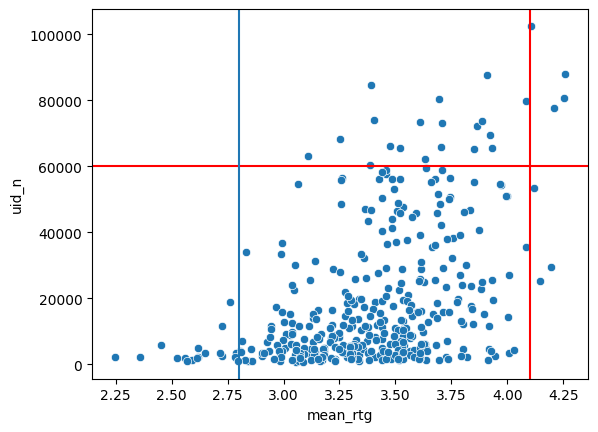

In [ ]:
sns.scatterplot(mean_ratings, x = 'mean_rtg', y = 'uid_n')
plt.axhline(y=60000, color = 'r')
plt.axvline(x=4.1, color = 'r')
plt.axvline(x=2.8)

In [ ]:
df_up = mean_ratings[lambda x: x.mean_rtg > 4.2]
df_up = df_up[lambda x: x.uid_n >= 60000]
df_up.sort_values('mean_rtg')
# so for all this movies we can set rtg = 4 , according to median and mean

,mid,mean_rtg,med_rtg,uid_n
121,122,4.21,4.0,77664
6,7,4.25,4.0,80809
13,14,4.26,4.0,87863


In [ ]:
df = df.fillna(0)
dfn = df[lambda x: x.rtg == 0]
df = df.dropna()

In [ ]:
df_up['rtg'] = 5

In [ ]:
dfn = dfn.merge(df_up, on = 'mid')
dfn = dfn.drop(columns = ['mean_rtg', 'med_rtg', 'uid_n', 'rtg_x'], axis = 0)
dfn = dfn.rename(columns={'rtg_y':'rtg'})

In [ ]:
df = pd.concat([df,dfn], ignore_index = True)

In [ ]:
df['rtg'] = df['rtg']**2

In [ ]:
df = df.replace(0,np.NaN)

Below is a baseline model that produces the baseline result on Kaggle leaderboard (LB).

In [ ]:
if 'dfMtx' in vars(): del dfMtx   # release ~400MB RAM
dfK = df[df.rtg!=df.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df[df.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfX

mid,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
uid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,4.0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.0,NaN,25.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,NaN,1.0,9.0,25.0,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18364,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfX.iloc[:2,:30]   # original matrix with NaN's

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,4.0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,...,NaN,NaN,9.0,NaN,NaN,25.0,NaN,NaN,NaN,NaN
2,25.0,NaN,25.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.0,NaN,NaN,9.0,NaN,NaN,9.0,NaN


In [ ]:
dfX_est.loc[:2,:30]  # naive imputation with column means

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,11.93,13.45,4.0,14.77,11.94,14.13,25.00,13.54,8.83,12.59,...,15.97,10.35,9.0,11.53,13.51,25.0,10.4,10.99,12.35,13.52
2,25.00,13.45,25.0,9.00,11.94,14.13,19.02,13.54,8.83,12.59,...,15.97,10.35,25.0,11.53,13.51,9.0,10.4,10.99,9.00,13.52


In [ ]:
dfX_est

mid,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
uid,,,,,,,,,,,,,,,,,,,,,
1,11.93,13.45,4.0,14.77,11.94,14.13,25.00,13.54,8.83,12.59,...,8.74,13.73,10.22,13.95,6.28,10.23,7.61,11.18,12.39,15.44
2,25.00,13.45,25.0,9.00,11.94,14.13,19.02,13.54,8.83,12.59,...,8.74,13.73,10.22,13.95,6.28,10.23,7.61,11.18,12.39,15.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,11.93,1.00,9.0,25.00,11.94,14.13,9.00,13.54,8.83,12.59,...,8.74,13.73,10.22,13.95,6.28,10.23,7.61,11.18,12.39,15.44
18364,11.93,13.45,16.0,14.77,11.94,14.13,19.02,13.54,8.83,12.59,...,8.74,13.73,10.22,13.95,6.28,10.23,7.61,11.18,12.39,15.44


In [ ]:
np.random.seed(0)
for _ in range(11):                             # apply truncated SVD approximation a few times
  U, D, Vt = svds(dfX_est.to_numpy(), k=7)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est.loc[1:n, 1:p] = U @ np.diag(D) @ Vt  # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)       # mask locations of NaN's
  dfX_est[mask] = dfX[mask]   # place original/known ratings back into estimated uid×mid matrix
dfX_est.loc[:2,:30]           # a "better" approximation of underlying ratings distribution (or so we hope ;) )

(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)
(18364, 7) (7,) (7, 380) (7, 7) (18364, 7) (18364, 380)


mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,6.82,15.36,4.0,10.55,11.11,9.7,25.00,13.62,6.56,9.81,...,24.19,8.54,9.0,12.01,13.17,25.0,8.42,7.95,10.81,13.10
2,25.00,20.44,25.0,9.00,11.65,20.3,19.95,21.74,12.10,16.17,...,13.96,12.68,25.0,12.30,13.71,9.0,14.00,13.33,9.00,13.24


In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfX_est_L.merge(dfK, on=['mid','uid'], suffixes=['','_']).drop('rtg_', axis=1)
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK

,mid,uid,rtg
1,1,1,7
147061,1,388,14
...,...,...,...
5568899,379,14655,12
5647180,380,14861,17


In [ ]:
dfK

,mid,uid,rtg
1,1,1,7
147061,1,388,14
...,...,...,...
5568899,379,14655,12
5647180,380,14861,17


In [ ]:
dfK['rtg'] = np.round(dfK['rtg']**0.5)



In [ ]:
dfK['rtg'] = dfK['rtg'].astype(int)

In [ ]:
dfK[['rtg']].sort_index()

,rtg
1,3
382,4
...,...
6977889,3
6978071,4


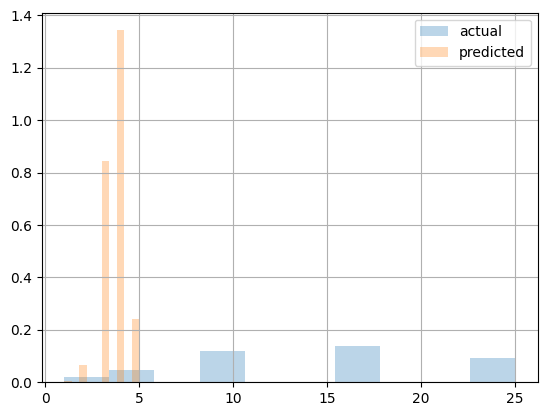

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dfK.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
ToCSV(dfK[['rtg']].sort_index(), 'MySubmission2')

In [ ]:
dfK[['rtg']].sort_index()

,rtg
1,3
382,4
...,...
6977889,3
6978071,4


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 18 sec


## 💡**Starter Ideas**

1. Tune model **hyperparameters**.
  1. SVD's $k$ might be user-perceived movie genres (perhaps, an average user categorizes movies into just 5 or 50 genres) [🎦](https://youtu.be/sooj-_bXWgk)
1. Try smarter **sampling** from the training set to avoid using all observations (due to time constraint)
  1. Some movies may have consistent high/low ratings and do not distinguish user preferences (just add to runtime)
1. Try SVD on groups (say movie genres) with the largest impact on overall accuracy
1. Try smarter initial imputation, perhaps, conditioned on movie genres or other observed features
1. Try clustering techniques from [SKL](https://scikit-learn.org/stable/modules/clustering.html)
1. Try engineering new features using Movies' data (`movies.csv`)
1. Try supervised approach on clusters or engineered features
1. Try shift/scale ratings. Recall: SVD seeks largest quadratic error from mean without shifting first, like variance does. Since $1^2\ll5^2$, SVD might work better for higher ratings.
  1. Note: the baseline model squeezes predictions towards ratings 3 and 4, which is not the original distribution.
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA. Are there movies that are liked by most viewers?
1. Try Robust PCA (RPC) [🎦](https://www.youtube.com/watch?v=yDpz0PqULXQ), [RPCA Github](https://github.com/dganguli/robust-pca)
1. Find polarized movies and tune for them (like "*Napoleon Dynamite*"). See [&#127910;](https://youtu.be/ImpV70uLxyw)
1. Try KNN [📄](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.596&rep=rep1&type=pdf), [📄](https://scholar.google.com/scholar?q=knn+netflix+prize)
1. Learn more methods to build/use latent representations [🎦](https://youtu.be/n3RKsY2H-NE),  [📄](https://ieeexplore.ieee.org/abstract/document/5197422), [📄](https://scholar.google.com/scholar?q=netflix+prize+challenge), [&#127910;](https://www.youtube.com/results?search_query=netflix+prize+svd), [📄](https://www.aaai.org/Papers/AAAI/2002/AAAI02-029.pdf),

# EDA

In [ ]:
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/27nov23hse-netflix/XY_Netflix.csv', low_memory=False); df

,uid,mid,rtg
0,1,1,NaN
1,2,2,NaN
...,...,...,...
7402070,49692,126,4.0
7402071,9783,37,1.0


In [ ]:
df1 = df.dropna(subset=['rtg'])
mean_ratings = df1.groupby('mid').agg({'rtg': ['mean', 'median'], 'uid': 'nunique'}).reset_index()
mean_ratings.columns = ['mid', 'mean_rtg', 'med_rtg','uid_n', ]


In [ ]:
mean_ratings.sort_values('mean_rtg', ascending=False)


,mid,mean_rtg,med_rtg,uid_n
13,14,4.26,4.0,87863
6,7,4.25,4.0,80809
...,...,...,...,...
251,252,2.36,2.0,2273
374,375,2.25,2.0,2126


<Axes: xlabel='mean_rtg', ylabel='uid_n'>

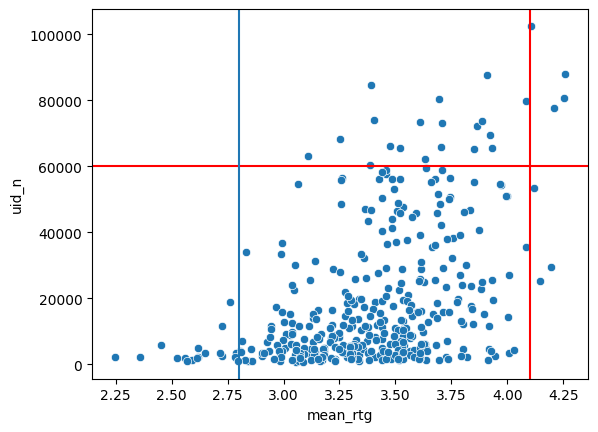

In [ ]:
sns.scatterplot(mean_ratings, x = 'mean_rtg', y = 'uid_n')
plt.axhline(y=60000, color = 'r')
plt.axvline(x=4.1, color = 'r')
plt.axvline(x=2.8)

In [ ]:
df_up = mean_ratings[lambda x: x.mean_rtg > 4.2]
df_up = df_up[lambda x: x.uid_n >= 60000]
df_up.sort_values('mean_rtg')
# so for all this movies we can set rtg = 4 , according to median and mean

,mid,mean_rtg,med_rtg,uid_n
121,122,4.21,4.0,77664
6,7,4.25,4.0,80809
13,14,4.26,4.0,87863


In [ ]:
df = df.fillna(0)
dfn = df[lambda x: x.rtg == 0]
df = df.dropna()

In [ ]:
df_up['rtg'] = 5

In [ ]:
df_upn = df_up[lambda x: x.mean_rtg < 4.1]
df_upu = df_up[lambda x: x.mean_rtg >= 4.1]
df_upn['rtg'] = 4
df_upu['rtg'] = 5
df_up = pd.concat([df_upu, df_upn], ignore_index=True)

In [ ]:
dfn

,uid,mid,rtg
0,7,7,5
1,13,7,5
...,...,...,...
875,18304,122,5
876,18344,122,5


In [ ]:
dfn = dfn.merge(df_up, on = 'mid')
dfn = dfn.drop(columns = ['mean_rtg', 'med_rtg', 'uid_n', 'rtg_x'], axis = 0)
dfn = dfn.rename(columns={'rtg_y':'rtg'})

In [ ]:
df = pd.concat([df,dfn], ignore_index = True)

In [ ]:
df


,uid,mid,rtg
0,1,1,0.0
1,2,2,0.0
...,...,...,...
7402685,18304,122,5.0
7402686,18344,122,5.0


In [ ]:
df_m = pd.read_csv('/content/drive/MyDrive/27nov23hse-netflix/movies.csv', low_memory=False); df_m

,mid,Year,Name,voteAvg,voteCnt,popularity,duration,income,budget,releaseDate,...,origLang,spokenLang,ttl,origTtl,URL,kwds,desc,prodComp,prodCtry,tagline
0,1,2004,The Village,6.2,1071,27.49,108.0,256697520,60000000,7/30/04,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Village,The Village,NaN,"[{""id"": 1328, ""name"": ""secret""}, {""id"": 5774, ...",When a willful young man tries to venture beyo...,"[{""name"": ""Scott Rudin Productions"", ""id"": 258...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",There is no turning back
1,2,1997,Liar Liar,6.4,1424,26.72,86.0,181000000,45000000,3/21/97,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Liar Liar,Liar Liar,NaN,"[{""id"": 387, ""name"": ""california""}, {""id"": 102...",Fletcher Reede is a fast-talking attorney and ...,"[{""name"": ""Imagine Entertainment"", ""id"": 23}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",Trust me.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,379,1999,The Big Tease,5.8,6,0.50,87.0,0,0,1/1/99,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Big Tease,The Big Tease,thebigtease.warnerbros.com/index.html,"[{""id"": 928, ""name"": ""hairdresser""}, {""id"": 19...",Thinking he's competing in Los Angeles' hot Pl...,[],[],He saw. He combed. He conquered.
379,380,2004,Tae Guk Gi: The Brotherhood of War,7.4,133,9.57,140.0,15,0,2/5/04,...,ko,"[{""iso_639_1"": ""ko"", ""name"": ""\ud55c\uad6d\uc5...",Tae Guk Gi: The Brotherhood of War,태극기 휘날리며,NaN,"[{""id"": 41586, ""name"": ""archaeologist""}, {""id""...","In 1950, in South Korea, shoe-shiner Jin-tae L...","[{""name"": ""Showbox Entertainment"", ""id"": 11420}]","[{""iso_3166_1"": ""KR"", ""name"": ""South Korea""}]",NaN


In [ ]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mid              380 non-null    int64  
 1   Year             380 non-null    int64  
 2   Name             380 non-null    object 
 3   voteAvg          380 non-null    float64
 4   voteCnt          380 non-null    int64  
 5   popularity       380 non-null    float64
 6   duration         380 non-null    float64
 7   income           380 non-null    int64  
 8   budget           380 non-null    int64  
 9   releaseDate      380 non-null    object 
 10  Action           380 non-null    int64  
 11  Adventure        380 non-null    int64  
 12  Animation        380 non-null    int64  
 13  Comedy           380 non-null    int64  
 14  Crime            380 non-null    int64  
 15  Documentary      380 non-null    int64  
 16  Drama            380 non-null    int64  
 17  Family          

In [ ]:
df_m = df_m.drop(columns = ['origLang',
                            'spokenLang' ,
                            'ttl',
                            'origTtl',
                            'URL',
                            'kwds',
                            'desc',
                            'prodComp',
                            'prodCtry',
                            'tagline' ,
                            'Name',
                            'voteCnt',
                            'duration',
                            'income',
                            'budget',
                            'releaseDate'] , axis = 0)

In [ ]:
df_m

,mid,Year,voteAvg,popularity,Action,Adventure,Animation,Comedy,Crime,Documentary,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,2004,6.2,27.49,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2,1997,6.4,26.72,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,379,1999,5.8,0.50,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
379,380,2004,7.4,9.57,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


## Kmeans clustering by genres

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame df with movie_id and binary genre representation columns
# Replace 'df' with the actual name of your DataFrame

# Select relevant genre columns for clustering
X = df_m.iloc[:, 1:]  # Assuming genre representation columns start from the second column

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
num_clusters = 5  # Example: specifying 5 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_m['genre'] = kmeans.fit_predict(X_scaled)

# The 'cluster' column now contains the cluster assignment for each movie based on the genre representation
genre_value_counts = df_m['genre'].value_counts()
genre_value_counts.info()

<class 'pandas.core.series.Series'>
Int64Index: 5 entries, 4 to 3
Series name: genre
Non-Null Count  Dtype
--------------  -----
5 non-null      int64
dtypes: int64(1)
memory usage: 80.0 bytes


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df = df.merge(df_m[['genre', 'mid']], on='mid', how='left')


In [ ]:
df['rtg'] = df['rtg']**2

In [ ]:
genre_value_counts = df['genre'].value_counts()

# Print the count of unique values
print(genre_value_counts)



4    3535929
2    2018092
      ...   
1     483936
3     270912
Name: genre, Length: 5, dtype: int64


In [ ]:
df_m1 = df[lambda x: x.genre == 0]

df_m2 = df[lambda x: x.genre == 1]

df_m3 = df[lambda x: x.genre == 2]

df_m4 = df[lambda x: x.genre == 3]

df_m5 = df[lambda x: x.genre == 4]

In [ ]:
df_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1093203 entries, 5 to 7402064
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   uid     1093203 non-null  int64  
 1   mid     1093203 non-null  int64  
 2   rtg     1093203 non-null  float64
 3   genre   1093203 non-null  int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 37.5 MB


# 0

In [ ]:
df = df.replace(0,np.NaN)

In [ ]:
dfK = df[df.rtg!=df.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df[df.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfX

mid,6,16,17,21,24,36,49,51,79,86,...,309,312,323,329,330,342,346,360,365,370
uid,,,,,,,,,,,,,,,,,,,,,
6,NaN,25.0,9.0,NaN,NaN,NaN,4.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18361,NaN,9.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18363,NaN,16.0,4.0,25.0,NaN,9.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfi = dfX.index
dfc = dfX.columns

In [ ]:
dfi

Int64Index([    6,    18,    19,    21,    24,    27,    40,    43,    51,
               56,
            ...
            18264, 18279, 18301, 18316, 18319, 18328, 18332, 18340, 18361,
            18363],
           dtype='int64', name='uid', length=2900)

In [ ]:

np.random.seed(0)
for _ in range(5):
  U, D, Vt = svds(dfX_est.to_numpy(), k=10)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)
  #dfX_est = np.array(dfX_est)
  dfX = np.array(dfX)      # mask locations of NaN's
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix
  dfX_est = pd.DataFrame(dfX_est)
  dfX = pd.DataFrame(dfX)   # a "better" approximation of underlying ratings distribution (or so we hope ;) )


(18364, 10) (10,) (10, 380) (10, 10) (18364, 10) (18364, 380)
(18364, 10) (10,) (10, 380) (10, 10) (18364, 10) (18364, 380)
(18364, 10) (10,) (10, 380) (10, 10) (18364, 10) (18364, 380)
(18364, 10) (10,) (10, 380) (10, 10) (18364, 10) (18364, 380)
(18364, 10) (10,) (10, 380) (10, 10) (18364, 10) (18364, 380)


In [ ]:
dfX_est = pd.DataFrame(dfX_est)

In [ ]:
dfX_est.index = dfi
dfX_est.columns = dfc

In [ ]:
dfX_est.max

<bound method NDFrame._add_numeric_operations.<locals>.max of mid      6      16     17     21     24     36     49     51     79     86   \
uid                                                                           
6      18.38  25.00   9.00  16.08   9.73  16.20   4.00   9.00  10.65  14.12   
18     14.15  18.49  14.36  15.76  10.82  16.30  12.01  14.14  11.74  12.97   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
18361   9.61   9.00  14.19  13.16  16.00  14.57   8.02  16.72  13.38  13.93   
18363   7.68  16.00   4.00  25.00   7.80   9.00   4.00   0.39   8.98  10.12   

mid    ...    309    312    323    329    330    342    346    360    365  \
uid    ...                                                                  
6      ...  14.57  12.45  12.38   9.85  12.36  11.50  10.67  12.99  11.92   
18     ...  14.58  11.51  13.41  13.06  12.94  11.78  10.25  12.75  11.10   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfK.merge(dfX_est_L, on=['mid','uid'], how= 'left')
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg_y']
dfK = dfK.drop(columns = ['rtg_x','rtg_y'])
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK = dfK.fillna(value = {'rtg' : 4})

In [ ]:
dfK.rtg.fillna(0).astype(int).value_counts().to_frame().T

,16,13,12,11,14,15,25,10,17,9,...,21,6,22,5,23,24,4,3,1,2
rtg,4603,1811,1744,1621,1611,1444,1254,1126,875,835,...,202,200,140,95,83,68,42,34,18,13


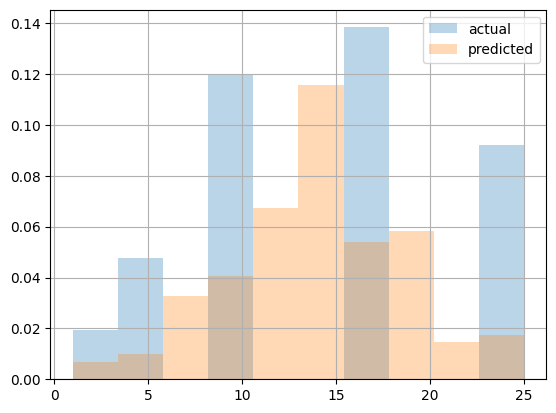

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dfK.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
dff = dfK

# 1

In [ ]:
df_m1 = df_m1.drop(columns = 'genre', axis = 0)

In [ ]:
df_m1 = df_m1.replace(0,np.NaN)

In [ ]:
dfK = df_m1[df_m1.rtg!=df_m1.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df_m1[df_m1.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfX

mid,6,16,17,21,24,36,49,51,79,86,...,309,312,323,329,330,342,346,360,365,370
uid,,,,,,,,,,,,,,,,,,,,,
6,NaN,25.0,9.0,NaN,NaN,NaN,4.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18361,NaN,9.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18363,NaN,16.0,4.0,25.0,NaN,9.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfi = dfX.index
dfc = dfX.columns

In [ ]:
dfi

Int64Index([    6,    18,    19,    21,    24,    27,    40,    43,    51,
               56,
            ...
            18264, 18279, 18301, 18316, 18319, 18328, 18332, 18340, 18361,
            18363],
           dtype='int64', name='uid', length=2900)

In [ ]:

np.random.seed(0)
for _ in range(7):
  U, D, Vt = svds(dfX_est.to_numpy(), k=12)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)
  #dfX_est = np.array(dfX_est)
  dfX = np.array(dfX)      # mask locations of NaN's
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix
  dfX_est = pd.DataFrame(dfX_est)
  dfX = pd.DataFrame(dfX)   # a "better" approximation of underlying ratings distribution (or so we hope ;) )


(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)
(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)
(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)
(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)
(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)
(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)
(2900, 12) (12,) (12, 55) (12, 12) (2900, 12) (2900, 55)


In [ ]:
dfX_est = pd.DataFrame(dfX_est)

In [ ]:
dfX_est.index = dfi
dfX_est.columns = dfc

In [ ]:
dfX_est.max

<bound method NDFrame._add_numeric_operations.<locals>.max of mid      6      16     17     21     24     36     49     51     79     86   \
uid                                                                           
6      18.38  25.00   9.00  16.08   9.73  16.20   4.00   9.00  10.65  14.12   
18     14.15  18.49  14.36  15.76  10.82  16.30  12.01  14.14  11.74  12.97   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
18361   9.61   9.00  14.19  13.16  16.00  14.57   8.02  16.72  13.38  13.93   
18363   7.68  16.00   4.00  25.00   7.80   9.00   4.00   0.39   8.98  10.12   

mid    ...    309    312    323    329    330    342    346    360    365  \
uid    ...                                                                  
6      ...  14.57  12.45  12.38   9.85  12.36  11.50  10.67  12.99  11.92   
18     ...  14.58  11.51  13.41  13.06  12.94  11.78  10.25  12.75  11.10   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfK.merge(dfX_est_L, on=['mid','uid'], how= 'left')
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg_y']
dfK = dfK.drop(columns = ['rtg_x','rtg_y'])
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK = dfK.fillna(value = {'rtg' : 4})

In [ ]:
dfK.rtg.fillna(0).astype(int).value_counts().to_frame().T

,14,12,15,13,16,11,10,18,19,17,...,22,21,6,5,4,23,1,3,24,2
rtg,308,278,264,249,223,200,167,160,160,159,...,52,51,41,35,35,34,21,21,18,6


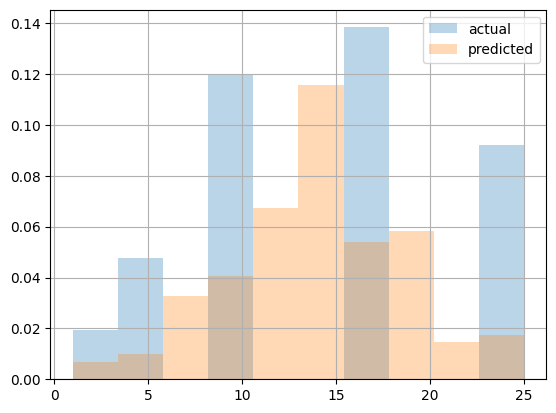

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dfK.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
dff = dfK

# 2

In [ ]:
df_m2 = df_m2.drop(columns = 'genre', axis = 0)

In [ ]:
df_m2 = df_m2.replace(0,np.NaN)

In [ ]:
dfK = df_m2[df_m2.rtg!=df_m2.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df_m2[df_m2.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfi = dfX.index
dfc = dfX.columns

In [ ]:

np.random.seed(0)
for _ in range(7):
  U, D, Vt = svds(dfX_est.to_numpy(), k=12)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)
  #dfX_est = np.array(dfX_est)
  dfX = np.array(dfX)      # mask locations of NaN's
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix
  dfX_est = pd.DataFrame(dfX_est)
  dfX = pd.DataFrame(dfX)   # a "better" approximation of underlying ratings distribution (or so we hope ;) )


(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)
(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)
(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)
(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)
(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)
(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)
(1236, 12) (12,) (12, 39) (12, 12) (1236, 12) (1236, 39)


In [ ]:
dfX_est = pd.DataFrame(dfX_est)

In [ ]:
dfX_est.index = dfi
dfX_est.columns = dfc

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfK.merge(dfX_est_L, on=['mid','uid'], how= 'left')
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg_y']
dfK = dfK.drop(columns = ['rtg_x','rtg_y'])
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK = dfK.fillna(value = {'rtg' : 4})

In [ ]:
dfK.rtg.fillna(0).astype(int).value_counts().to_frame().T

,14,13,18,15,16,12,11,17,4,10,...,7,21,6,5,23,22,24,25,3,2
rtg,201,146,130,111,103,96,80,71,63,58,...,21,19,17,10,8,8,6,6,4,2


In [ ]:
dff = pd.concat([dfK, dff], ignore_index=False)

# 3

In [ ]:
df_m3 = df_m3.drop(columns = 'genre', axis = 0)

In [ ]:
df_m3 = df_m3.replace(0,np.NaN)

In [ ]:
dfK = df_m3[df_m3.rtg!=df_m3.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df_m3[df_m3.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfi = dfX.index
dfc = dfX.columns

In [ ]:

np.random.seed(0)
for _ in range(7):
  U, D, Vt = svds(dfX_est.to_numpy(), k=12)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)
  #dfX_est = np.array(dfX_est)
  dfX = np.array(dfX)      # mask locations of NaN's
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix
  dfX_est = pd.DataFrame(dfX_est)
  dfX = pd.DataFrame(dfX)   # a "better" approximation of underlying ratings distribution (or so we hope ;) )


(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)
(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)
(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)
(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)
(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)
(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)
(5360, 12) (12,) (12, 101) (12, 12) (5360, 12) (5360, 101)


In [ ]:
dfX_est = pd.DataFrame(dfX_est)

In [ ]:
dfX_est.index = dfi
dfX_est.columns = dfc

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfK.merge(dfX_est_L, on=['mid','uid'], how= 'left')
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg_y']
dfK = dfK.drop(columns = ['rtg_x','rtg_y'])
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK = dfK.fillna(value = {'rtg' : 4})

In [ ]:
dfK.rtg.fillna(0).astype(int).value_counts().to_frame().T

,13,14,12,11,15,16,10,17,9,18,...,7,6,22,24,23,5,4,1,2,3
rtg,483,462,446,431,429,368,354,328,269,260,...,131,103,99,81,73,68,52,42,28,28


In [ ]:
dff = pd.concat([dfK, dff], ignore_index=False)

# 4

In [ ]:
df_m4 = df_m4.drop(columns = 'genre', axis = 0)

In [ ]:
df_m4 = df_m4.replace(0,np.NaN)

In [ ]:
dfK = df_m4[df_m4.rtg!=df_m4.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df_m4[df_m4.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfi = dfX.index
dfc = dfX.columns

In [ ]:

np.random.seed(0)
for _ in range(7):
  U, D, Vt = svds(dfX_est.to_numpy(), k=11)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)
  #dfX_est = np.array(dfX_est)
  dfX = np.array(dfX)      # mask locations of NaN's
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix
  dfX_est = pd.DataFrame(dfX_est)
  dfX = pd.DataFrame(dfX)   # a "better" approximation of underlying ratings distribution (or so we hope ;) )


(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)
(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)
(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)
(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)
(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)
(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)
(628, 11) (11,) (11, 12) (11, 11) (628, 11) (628, 12)


In [ ]:
dfX_est = pd.DataFrame(dfX_est)

In [ ]:
dfX_est.index = dfi
dfX_est.columns = dfc

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfK.merge(dfX_est_L, on=['mid','uid'], how= 'left')
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg_y']
dfK = dfK.drop(columns = ['rtg_x','rtg_y'])
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK = dfK.fillna(value = {'rtg' : 4})

In [ ]:
dfK.rtg.fillna(0).astype(int).value_counts().to_frame().T

,15,18,16,4,13,14,10,12,11,17
rtg,181,170,169,74,52,25,22,7,2,2


In [ ]:
dff = pd.concat([dfK, dff], ignore_index=False)

# 5

In [ ]:
df_m5 = df_m5.drop(columns = 'genre', axis = 0)

In [ ]:
df_m5 = df_m5.replace(0,np.NaN)

In [ ]:
dfK = df_m5[df_m5.rtg!=df_m5.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df_m5[df_m5.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies


In [ ]:
dfi = dfX.index
dfc = dfX.columns

In [ ]:

np.random.seed(0)
for _ in range(7):
  U, D, Vt = svds(dfX_est.to_numpy(), k=10)    # find k eigenvectors (U,V) and eigenvalues (D)
  print(U.shape,D.shape, Vt.shape, np.diag(D).shape, (U @ np.diag(D)).shape,((U @ np.diag(D))@ Vt).shape)
  dfX_est = U @ np.diag(D) @ Vt # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  mask = ~np.isnan(dfX)
  #dfX_est = np.array(dfX_est)
  dfX = np.array(dfX)      # mask locations of NaN's
  dfX_est[mask] = dfX[mask] # place original/known ratings back into estimated uid×mid matrix
  dfX_est = pd.DataFrame(dfX_est)
  dfX = pd.DataFrame(dfX)   # a "better" approximation of underlying ratings distribution (or so we hope ;) )


(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)
(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)
(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)
(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)
(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)
(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)
(9179, 10) (10,) (10, 173) (10, 10) (9179, 10) (9179, 173)


In [ ]:
dfX_est = pd.DataFrame(dfX_est)

In [ ]:
dfX_est.index = dfi
dfX_est.columns = dfc

In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().round(0).astype(int).reset_index().rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfK.merge(dfX_est_L, on=['mid','uid'], how= 'left')
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg_y']
dfK = dfK.drop(columns = ['rtg_x','rtg_y'])
dfK['rtg'] = dfK['rtg'].clip(1, 25)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK = dfK.fillna(value = {'rtg' : 4})

In [ ]:
dfK.rtg.fillna(0).astype(int).value_counts().to_frame().T

,13,12,14,15,11,16,17,10,18,19,...,7,22,23,6,24,5,4,1,3,2
rtg,890,812,800,769,752,711,640,607,503,463,...,182,182,148,124,114,93,49,46,39,29


In [ ]:
dff = pd.concat([dfK, dff], ignore_index=False)

# itog

In [ ]:
dff.index = (dff.uid-1)*dff.mid.max()+dff.mid

In [ ]:
dff.rtg.fillna(0).astype(int).value_counts().to_frame().T

,16,13,12,11,14,15,25,10,17,9,...,21,6,22,5,23,24,4,3,1,2
rtg,4603,1811,1744,1621,1611,1444,1254,1126,875,835,...,202,200,140,95,83,68,42,34,18,13


In [ ]:
dff['rtg'] = np.round(dff['rtg']**0.5)



In [ ]:
dff['rtg'] = dff['rtg'].astype(int)

In [ ]:
dff[['rtg']].sort_index()

,rtg
1,2
382,4
...,...
6977889,3
6978071,4


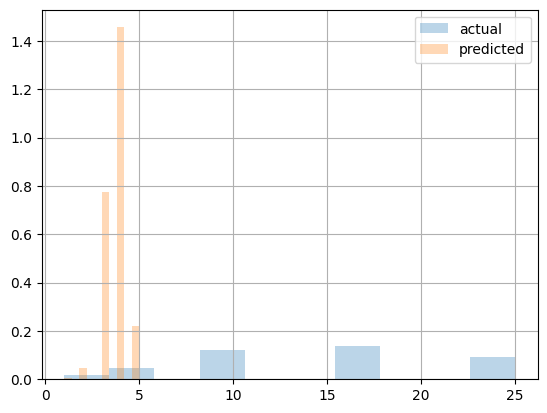

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dff.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
ToCSV(dff[['rtg']].sort_index(), 'MySubmission')

# chto-to

In [ ]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [ ]:
reader = Reader(rating_scale=(1, 5))  # Define the rating scale
data = Dataset.load_from_df(df_m1[['uid', 'mid', 'rtg']], reader)

# Use SVD for matrix completion
algo = SVD()

# Train-test split (Optional but recommended)
trainset, testset = train_test_split(data, test_size=0.2)

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict the missing ratings
predictions = algo.test(testset)





In [ ]:
# Convert predictions to a dictionary for faster lookup
prediction_dict = {(pred.uid, pred.iid): pred.est for pred in predictions}

# Create a boolean mask for missing ratings
missing_ratings_mask = df['rtg'].isnull()

# Create a composite key for faster lookup
df['composite_key'] = list(zip(df['uid'], df['mid']))

# Update the missing ratings in the original DataFrame in a vectorized manner
df.loc[missing_ratings_mask, 'rtg'] = df.loc[missing_ratings_mask, 'composite_key'].map(prediction_dict)

# Drop the temporary composite key column
df = df.drop('composite_key', axis=1)



In [ ]:
df_m3 = df[lambda x: x.genre == 0]


In [ ]:
# FOR GENRE 2


data = Dataset.load_from_df(df_m2[['uid', 'mid', 'rtg']], reader)

# Use SVD for matrix completion
algo = SVD()

# Train-test split (Optional but recommended)
trainset, testset = train_test_split(data, test_size=0.2)

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict the missing ratings
predictions = algo.test(testset)
# Convert predictions to a dictionary for faster lookup
prediction_dict = {(pred.uid, pred.iid): pred.est for pred in predictions}

# Create a boolean mask for missing ratings
missing_ratings_mask = df['rtg'].isnull()

# Create a composite key for faster lookup
df['composite_key'] = list(zip(df['uid'], df['mid']))

# Update the missing ratings in the original DataFrame in a vectorized manner
df.loc[missing_ratings_mask, 'rtg'] = df.loc[missing_ratings_mask, 'composite_key'].map(prediction_dict)

# Drop the temporary composite key column
df = df.drop('composite_key', axis=1)

In [ ]:
df_m3.rtg.fillna(0).astype(int).value_counts().to_frame().T

""
rtg


In [ ]:
# FOR GENRE 3
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_m3[['uid', 'mid', 'rtg']], reader)

# Use SVD for matrix completion
algo = SVD(n_epochs=20, n_factors=100)  # Adjust the number of epochs and factors according to your specific use case

# Train the algorithm on the entire dataset with the optimized parameters
trainset = data.build_full_trainset()
algo.fit(trainset)

# Predict all missing ratings with the optimized algorithm and parameters
testset = trainset.build_anti_testset()
predictions = algo.test(testset)


# Convert predictions to a dictionary for faster lookup
prediction_dict = {(pred.uid, pred.iid): pred.est for pred in predictions}

# Create a boolean mask for missing ratings
missing_ratings_mask = df['rtg'].isnull()

# Create a composite key for faster lookup
df['composite_key'] = list(zip(df['uid'], df['mid']))

# Update the missing ratings in the original DataFrame in a vectorized manner
df.loc[missing_ratings_mask, 'rtg'] = df.loc[missing_ratings_mask, 'composite_key'].map(prediction_dict)

# Drop the temporary composite key column
df = df.drop('composite_key', axis=1)

In [ ]:
df.rtg.fillna(0).astype(int).value_counts().to_frame().T

,4,3,5,2,1,0
rtg,2451087,2120585,1632241,842056,340222,15881


In [ ]:
genre_value_counts = df['genre'].value_counts()
genre_value_counts

0    3825939
1    2560505
2    1015628
Name: genre, dtype: int64

In [ ]:
a = len(predictions)
a

765188

In [ ]:
df_m3.rtg.fillna(0).astype(int).value_counts().to_frame().T

,4,3,5,2,1,0
rtg,1290319,1062813,883739,409726,169034,10308


In [ ]:
df_m2.rtg.fillna(0).astype(int).value_counts().to_frame().T

,4,3,5,2,1,0
rtg,314920,301177,217980,127398,51400,2753


In [ ]:
df_m1.rtg.fillna(0).astype(int).value_counts().to_frame().T

,4,3,5,2,1,0
rtg,845848,756595,526403,304932,119788,6939


# Updated baseline

In [ ]:
df_m1.rtg.fillna(0).astype(int).value_counts().to_frame().T
df_m2.rtg.fillna(0).astype(int).value_counts().to_frame().T
df_m3.rtg.fillna(0).astype(int).value_counts().to_frame().T

,4,3,5,2,1,0
rtg,346247,333159,219755,137584,53504,2954


,4,3,5,2,1,0
rtg,150757,142969,104343,59876,24690,1301


,4,3,5,2,1,0
rtg,681278,587350,425844,229587,88541,5492


In [ ]:

# Filter for NaN ratings
dfK = df_m1[df_m1.rtg.isna()]

# Select all ratings for users requiring predictions
dfX = df_m1[df_m1.uid.isin(dfK.uid.unique())]

# Convert to matrix format for SVD
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')

# Fill NaN with movies' average ratings
dfX_est = dfX.fillna(dfX.stack().mean())

# Perform truncated SVD approximation
U, D, Vt = svds(csc_matrix(dfX_est.values), k=10)

# Update the SVD approximation into the DataFrame
dfX_est = pd.DataFrame(U @ np.diag(D) @ Vt, columns=dfX.columns, index=dfX.index)

# Reshape the matrix into tall format with integer ratings
dfX_est_L = dfX_est.stack().reset_index(name='rtg').round(0).astype(int)

# Merge with dfK on movie ID and user ID
dfK_merged = dfX_est_L.merge(dfK, on=['mid', 'uid'], suffixes=['', '_']).drop('rtg_', axis=1)

# Adjust index
dfK_merged.index = (dfK_merged.uid - 1) * dfK_merged.mid.max() + dfK_merged.mid

# Restrict the ratings within the range 1-5
dfK_merged['rtg'] = dfK_merged['rtg'].clip(1, 5)

print(dfK_merged)             # number of users and movies

NameError: ignored

In [ ]:
missing_rows_in_merged = dfK[~dfK.index.isin(dfK_merged.index)]

# Display the missing rows
print(missing_rows_in_merged)


In [ ]:
dfK_merged = dfX_est_L.merge(dfK, on=['mid', 'uid'], suffixes=['', '_']).drop('rtg_', axis=1)

# Adjust index
dfK_merged.index = (dfK_merged.uid - 1) * dfK_merged.mid.max() + dfK_merged.mid

# Restrict the ratings within the range 1-5
dfK_merged['rtg'] = dfK_merged['rtg'].clip(1, 5)
unique_uid_dfK = dfK['uid'].nunique()
unique_mid_dfK = dfK['mid'].nunique()

unique_uid_dfK_merged = dfK_merged['uid'].nunique()
unique_mid_dfK_merged = dfK_merged['mid'].nunique()

print(f"Unique UID count in dfK: {unique_uid_dfK}")
print(f"Unique MID count in dfK: {unique_mid_dfK}")

print(f"Unique UID count in dfK_merged: {unique_uid_dfK_merged}")
print(f"Unique MID count in dfK_merged: {unique_mid_dfK_merged}")
missing_uid_in_merged = set(dfK['uid']) - set(dfK_merged['uid'])
print("Missing UID in dfK_merged:", missing_uid_in_merged)

missing_uid_data_in_dfK = dfK[dfK['uid'].isin(missing_uid_in_merged)]

# Select the rows in dfK_merged where the 'uid' is in the set of missing 'uid' values
missing_uid_data_in_dfK_merged = dfK_merged[dfK_merged['uid'].isin(missing_uid_in_merged)]

# Inspect the details of the missing 'uid' data
print("Details of missing UID in dfK:")
print(missing_uid_data_in_dfK)

print("\nDetails of missing UID in dfK_merged:")
print(missing_uid_data_in_dfK_merged)
missing_uid_data_in_dfK_merged




In [ ]:
missing_uid_data_in_dfK['rtg'] = 3


In [ ]:
missing_uid_data_in_dfK

In [ ]:
dfK = pd.concat([dfK_merged, missing_uid_data_in_dfK], ignore_index=True)

In [ ]:
dff = dfK

In [ ]:

# Filter for NaN ratings
dfK = df_m2[df_m2.rtg.isna()]

# Select all ratings for users requiring predictions
dfX = df_m2[df_m2.uid.isin(dfK.uid.unique())]

# Convert to matrix format for SVD
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')

# Fill NaN with movies' average ratings
dfX_est = dfX.fillna(dfX.stack().mean())

# Perform truncated SVD approximation
U, D, Vt = svds(csc_matrix(dfX_est.values), k=10)

# Update the SVD approximation into the DataFrame
dfX_est = pd.DataFrame(U @ np.diag(D) @ Vt, columns=dfX.columns, index=dfX.index)

# Reshape the matrix into tall format with integer ratings
dfX_est_L = dfX_est.stack().reset_index(name='rtg').round(0).astype(int)

# Merge with dfK on movie ID and user ID
dfK_merged = dfX_est_L.merge(dfK, on=['mid', 'uid'], suffixes=['', '_']).drop('rtg_', axis=1)

# Adjust index
dfK_merged.index = (dfK_merged.uid - 1) * dfK_merged.mid.max() + dfK_merged.mid

# Restrict the ratings within the range 1-5
dfK_merged['rtg'] = dfK_merged['rtg'].clip(1, 5)

print(dfK_merged)             # number of users and movies

In [ ]:
missing_uid_in_merged = set(dfK['uid']) - set(dfK_merged['uid'])
print("Missing UID in dfK_merged:", missing_uid_in_merged)

# Select the rows in dfK where the 'uid' is in the set of missing 'uid' values
missing_uid_data_in_dfK = dfK[dfK['uid'].isin(missing_uid_in_merged)]

# Select the rows in dfK_merged where the 'uid' is in the set of missing 'uid' values
missing_uid_data_in_dfK_merged = dfK_merged[dfK_merged['uid'].isin(missing_uid_in_merged)]

# Inspect the details of the missing 'uid' data
print("Details of missing UID in dfK:")
print(missing_uid_data_in_dfK)

print("\nDetails of missing UID in dfK_merged:")
print(missing_uid_data_in_dfK_merged)

dfK = pd.concat([dfK_merged, missing_uid_data_in_dfK_merged], ignore_index=True)

In [ ]:
missing_uid_data_in_dfK['rtg'] = 4

In [ ]:
dfK = pd.concat([dfK_merged, missing_uid_data_in_dfK], ignore_index=True)

In [ ]:
dff = pd.concat([dff,dfK], ignore_index=True)

In [ ]:

# Filter for NaN ratings
dfK = df_m3[df_m3.rtg.isna()]

# Select all ratings for users requiring predictions
dfX = df_m3[df_m3.uid.isin(dfK.uid.unique())]

# Convert to matrix format for SVD
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')

# Fill NaN with movies' average ratings
dfX_est = dfX.fillna(dfX.stack().mean())

# Perform truncated SVD approximation
U, D, Vt = svds(csc_matrix(dfX_est.values), k=10)

# Update the SVD approximation into the DataFrame
dfX_est = pd.DataFrame(U @ np.diag(D) @ Vt, columns=dfX.columns, index=dfX.index)

# Reshape the matrix into tall format with integer ratings
dfX_est_L = dfX_est.stack().reset_index(name='rtg').round(0).astype(int)

# Merge with dfK on movie ID and user ID
dfK_merged = dfX_est_L.merge(dfK, on=['mid', 'uid'], suffixes=['', '_']).drop('rtg_', axis=1)

# Adjust index
dfK_merged.index = (dfK_merged.uid - 1) * dfK_merged.mid.max() + dfK_merged.mid

# Restrict the ratings within the range 1-5
dfK_merged['rtg'] = dfK_merged['rtg'].clip(1, 5)

print(dfK_merged)             # number of users and movies

In [ ]:
missing_uid_in_merged = set(dfK['uid']) - set(dfK_merged['uid'])
print("Missing UID in dfK_merged:", missing_uid_in_merged)

# Select the rows in dfK where the 'uid' is in the set of missing 'uid' values
missing_uid_data_in_dfK = dfK[dfK['uid'].isin(missing_uid_in_merged)]

# Select the rows in dfK_merged where the 'uid' is in the set of missing 'uid' values
missing_uid_data_in_dfK_merged = dfK_merged[dfK_merged['uid'].isin(missing_uid_in_merged)]

# Inspect the details of the missing 'uid' data
print("Details of missing UID in dfK:")
print(missing_uid_data_in_dfK)

print("\nDetails of missing UID in dfK_merged:")
print(missing_uid_data_in_dfK_merged)

dfK = pd.concat([dfK_merged, missing_uid_data_in_dfK_merged], ignore_index=True)

In [ ]:
dff = pd.concat([dff,dfK], ignore_index=True)

In [ ]:
dff = dff['rtg'].dropna()

In [ ]:
dff.rtg.fillna(0).astype(int).value_counts().to_frame().T

In [ ]:
dff.index = dff['id']

In [ ]:
dff[['rtg']].sort_index()

In [ ]:
ToCSV(dff[['rtg']].sort_index(), 'MySubmission')